In [1]:
#@title ##### License
# Copyright 2018 The GraphNets Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

![](https://github.com/deepmind/graph_nets/raw/master/images/graph-nets-deepmind-shortest-path.gif)

# Tutorial of the Graph Nets library

The purpose of this tutorial is to get practical experience using the Graph Nets library via examples of:
1. Building graph data structures `graph_nets.graphs.GraphsTuple` using `graph_nets.utils_np` .
2. Operating with graph data structures in the tensorflow graph using `graph_nets.utils_tf` .
3. Feeding graphs to Graph Nets tensorflow modules in `graph_nets.modules` .
4. Building custom Graph Nets modules using the graph net building blocks provided in `graph_nets.blocks` .

For more information about graph networks, see our arXiv paper: [Relational inductive biases, deep learning, and graph networks](https://arxiv.org/abs/1806.01261).

In [2]:
#@title ### Install the Graph Nets library on this Colaboratory runtime  { form-width: "60%", run: "auto"}
#@markdown <br>1. Connect to a local or hosted Colaboratory runtime by clicking the **Connect** button at the top-right.<br>2. Choose "Yes" below to install the Graph Nets library on the runtime machine with:<br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;```pip install graph_nets```<br> Note, this works both with local and hosted Colaboratory runtimes.

install_graph_nets_library = "No"  #@param ["Yes", "No"]

if install_graph_nets_library.lower() == "yes":
  print("Installing Graph Nets library with:")
  print("  $ pip install graph_nets\n")
  print("Output message from command:\n")
  !pip install graph_nets
else:
  print("Skipping installation of Graph Nets library")

Skipping installation of Graph Nets library


In [3]:
#@title #### (Imports)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from graph_nets import blocks
from graph_nets import graphs
from graph_nets import modules
from graph_nets import utils_np
from graph_nets import utils_tf

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sonnet as snt
import tensorflow as tf

/Users/jambo/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/jambo/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



>[Tutorial of the Graph Nets library](#scrollTo=rPPRpGpz1Hce)

>[A Graph Net module](#scrollTo=jS0bIZykbaw4)

>>[The graphs.GraphsTuple class](#scrollTo=Tc355RxEak3h)

>[Creating graphs](#scrollTo=Rg3HRdEAyYi0)

>>[What's contained in a graph?](#scrollTo=VC023vAp0pAp)

>>[How to represent graphs as a graphs.GraphsTuple](#scrollTo=8sOteecpHj0Z)

>>>[Visualize the graphs using networkx](#scrollTo=saTlW6FUsQou)

>>>[Print the GraphsTuple fields](#scrollTo=o-HixEQ7sU6q)

>>[Different ways of expressing data as a graph](#scrollTo=JtUYYeERq2x2)

>>>[Graph with no features](#scrollTo=nz7RDJL1r8Mh)

>>>[Set (ie. graph without edges)](#scrollTo=efQtkXoFr5su)

>>>[Creating a GraphsTuple from a networkx graph](#scrollTo=oPrZFvcRr1yU)

>>[Working with tensor GraphsTuple's](#scrollTo=cSUY6pbYXE1i)

>>[Creating a constant tensor GraphsTuple from data dicts](#scrollTo=_kygzbsSXsHJ)

>>[GraphsTuple placeholders](#scrollTo=lQVz4xCbXr_J)

>>[Slicing graphs from within a batch](#scrollTo=acSavUGPXsZI)

>>[Concatenating GraphsTuples](#scrollTo=MLD2KEdEYldQ)

>[Graph Net modules](#scrollTo=VUzXQDdRaIKt)

>>[Creating a modules.GraphNetwork](#scrollTo=0rOU3rjRbK9O)

>>[Feeding a GraphsTuple to a Graph Net](#scrollTo=VsSIrvMEbV1W)

>>[Connecting a GraphNetwork recurrently](#scrollTo=HGK5xGBob3lb)

>[Graph Net building blocks](#scrollTo=qfhlV2qpah5O)

>>[Broadcast operations](#scrollTo=Ta0YenqKaq7E)

>>[Aggregators](#scrollTo=uE8bBiLbaoCX)

>>[blocks.EdgeBlock](#scrollTo=lE0e3bMna96z)

>>[blocks.NodeBlock](#scrollTo=FsqdEWjLa0kF)

>>[blocks.GlobalBlock](#scrollTo=JlNdE_rbbBOj)

>>[Block compositionality](#scrollTo=ZC_Y6dEZqNCx)

>[Various canonical Graph Net modules](#scrollTo=n4gULrAFbnwE)

>>[Independent Graph Net (modules.GraphIndependent)](#scrollTo=bHhltBuVv5hR)

>>[Message-passing neural networks (modules.InteractionNetwork, modules.CommNet)](#scrollTo=bJX9iMMIt8T9)

>>[Non-local neural networks (modules.SelfAttention)](#scrollTo=XMCMOdkNvJ58)

>>[Relation network (modules.RelationNetwork)](#scrollTo=bJAx7bZ5vM-e)

>>[Deep Sets (modules.DeepSets)](#scrollTo=ncp-swtyvQ0C)



## The [`graphs.GraphsTuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-graphsgraphstuple) class

The Graph Nets library contains models which operate on graph-structured data, so the first thing to understand is how graph-structured data is represented in the code. 

The `graph_nets.graphs.GraphsTuple` class, defined in [`graph_nets/graphs.py`](https://github.com/deepmind/graph_nets/blob/master/graph_nets/graphs.py), represents a **batches of one or more graphs**. All graph network modules take instances of `GraphsTuple` as input, and return instances of `GraphsTuple` as output. The graphs are *directed* (one-way edges), *attributed* (node-, edge-, and graph-level features are allowed), *multigraphs* (multiple edges can connect any two nodes, and self-edges are allowed). See Box 3, page 11 in [our companion arXiv paper](https://arxiv.org/pdf/1806.01261.pdf) for details.

A `GraphsTuple` has attributes:
- `n_node` (shape=[num_graphs]): Number of nodes in each graph in the batch.
- `n_edge` (shape=[num_graphs]): Number of edges in each graph in the batch.
- `globals` (shape=[num_graphs] + global_feature_dimensions): Global features for each graph in the batch.
- `nodes` (shape=[total_num_nodes] + node_feature_dimensions): Node features for each node in the batch of graphs.
- `edges` (shape=[total_num_edges] + edge_feature_dimensions): Edge features for each edge in the batch of graphs.
- `senders`(shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the source node of each directed edge in `edges`.
- `receivers` (shape=[total_num_edges]): Indices of the nodes in `nodes`, which indicate the destination node of each directed edge in `edges`.

The nodes and edges from the different graphs in the batch are concatenated along the first axis of the `nodes` and `edges` fields, and can be partitioned using the `n_node` and `n_edge` fields respectively.  Note, all but the "`n_*`" fields are optional (see examples below).

The attributes of a `GraphsTuple` instance are typically either Numpy arrays or TensorFlow tensors. The library contains utilities for manipulating graphs with each of these types of attributes, respectively:
  * `utils_np` (for Numpy arrays)
  * `utils_tf` (for TensorFlow tensors)

An important method of the `GraphsTuple` class is [`GraphsTuple.replace`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#graphsgraphstuplereplacekwargs): Similarly to `collections.namedtuple._replace` (in fact, `GraphsTuple` is sub-class of `collections.namedtuple`), this method creates a copy of the `GraphsTuple`, with references to all of the original attributes, by replacing some of them by the values provided as keyword arguments.

# Creating graphs

## What's contained in a graph?

Each graph will have a global feature, several nodes, and several edges. The graphs can have different numbers of nodes and edges, but the lengths of the global, node, and edge attribute vectors must be the same across graphs.
In order to create a `graphs.GraphsTuple` instance, we can define a `list` whose elements are `dict`s, with the following keys, that contain each graph's data:
- "globals": Each graph has a single `float`-valued feature vector.
- "nodes": Each graph has a set of nodes with `float`-valued feature vectors.
- "edges": Each graph has a set of edges with `float`-valued feature vectors.
- "senders": Each edge connects a sender node, represented by an `int`-valued node index, to a receiver node.
- "receivers": Each edge connects a sender node to a receiver node, represented by an `int`-valued node index.

Try running the cell below to create some dummy graph data.

In [4]:
# Global features for graph 0.
globals_0 = [1., 2., 3.]

# Node features for graph 0.
nodes_0 = [[10., 20., 30.],  # Node 0
           [11., 21., 31.],  # Node 1
           [12., 22., 32.],  # Node 2
           [13., 23., 33.],  # Node 3
           [14., 24., 34.]]  # Node 4

# Edge features for graph 0.
edges_0 = [[100., 200.],  # Edge 0
           [101., 201.],  # Edge 1
           [102., 202.],  # Edge 2
           [103., 203.],  # Edge 3
           [104., 204.],  # Edge 4
           [105., 205.]]  # Edge 5

# The sender and receiver nodes associated with each edge for graph 0.
senders_0 = [0,  # Index of the sender node for edge 0
             1,  # Index of the sender node for edge 1
             1,  # Index of the sender node for edge 2
             2,  # Index of the sender node for edge 3
             2,  # Index of the sender node for edge 4
             3]  # Index of the sender node for edge 5
receivers_0 = [1,  # Index of the receiver node for edge 0
               2,  # Index of the receiver node for edge 1
               3,  # Index of the receiver node for edge 2
               0,  # Index of the receiver node for edge 3
               3,  # Index of the receiver node for edge 4
               4]  # Index of the receiver node for edge 5

# Global features for graph 1.
globals_1 = [1001., 1002., 1003.]

# Node features for graph 1.
nodes_1 = [[1010., 1020., 1030.],  # Node 0
           [1011., 1021., 1031.]]  # Node 1

# Edge features for graph 1.
edges_1 = [[1100., 1200.],  # Edge 0
           [1101., 1201.],  # Edge 1
           [1102., 1202.],  # Edge 2
           [1103., 1203.]]  # Edge 3

# The sender and receiver nodes associated with each edge for graph 1.
senders_1 = [0,  # Index of the sender node for edge 0
             0,  # Index of the sender node for edge 1
             1,  # Index of the sender node for edge 2
             1]  # Index of the sender node for edge 3
receivers_1 = [0,  # Index of the receiver node for edge 0
               1,  # Index of the receiver node for edge 1
               0,  # Index of the receiver node for edge 2
               0]  # Index of the receiver node for edge 3

data_dict_0 = {
    "globals": globals_0,
    "nodes": nodes_0,
    "edges": edges_0,
    "senders": senders_0,
    "receivers": receivers_0
}

data_dict_1 = {
    "globals": globals_1,
    "nodes": nodes_1,
    "edges": edges_1,
    "senders": senders_1,
    "receivers": receivers_1
}

## How to represent graphs as a [`graphs.GraphsTuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#utils_npgraphs_tuple_to_data_dictsgraph)

The `utils_np` module contains a functions named [`utils_np.data_dicts_to_graphs_tuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#utils_npgraphs_tuple_to_data_dictsgraph), which takes a `list` of `dict`s with the keys specified above, and returns a `GraphsTuple` that represents the sequence of graphs.

The `data_dicts_to_graphs_tuple` function does three things:
1. It concatenates the data from the multiple graphs together along their innermost axes (i.e. the batch dimension). This allows the graph net to process the node and edge attributes by a shared function in parallel.
2. It counts up the numbers of nodes and edges per graph, and stores them in the fields "n_node" and "n_edge", respectively, where their lengths equal the number of graphs. This is used for keeping track of which nodes and edges belong to which graph, so they can be split up later, and so the graph can broadcast a graph's global attributes across its nodes and edges.
3. It adds an integer offset to the sender and receiver indices, which corresponds to the number of nodes in the preceding graphs. This allows the indices to correspond to the nodes and edges of their corresponding graph, after the node and edge attributes have been concatenated.

Try running the cell below to put the graph dictionaries into a `GraphsTuple` using `utils_np.data_dicts_to_graphs_tuple`.

In [5]:
data_dict_list = [data_dict_0, data_dict_1]
graphs_tuple = utils_np.data_dicts_to_graphs_tuple(data_dict_list)

### Visualize the graphs using `networkx`

A `GraphsTuple` can be converted into a `list` of `networkx` graph objects for easy visualization.

Try running the cell below to visualize the graphs we've just defined.

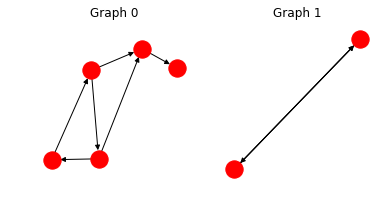

In [6]:
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
_, axs = plt.subplots(ncols=2, figsize=(6, 3))
for iax, (graph_nx, ax) in enumerate(zip(graphs_nx, axs)):
  nx.draw(graph_nx, ax=ax)
  ax.set_title("Graph {}".format(iax))

### Print the `GraphsTuple` fields

You can also print out the data contained in a `GraphsTuple` by running the cell below.

In [7]:
def print_graphs_tuple(graphs_tuple):
  print("Shapes of `GraphsTuple`'s fields:")
  print(graphs_tuple.map(lambda x: x if x is None else x.shape, fields=graphs.ALL_FIELDS))
  print("\nData contained in `GraphsTuple`'s fields:")
  print("globals:\n{}".format(graphs_tuple.globals))
  print("nodes:\n{}".format(graphs_tuple.nodes))
  print("edges:\n{}".format(graphs_tuple.edges))
  print("senders:\n{}".format(graphs_tuple.senders))
  print("receivers:\n{}".format(graphs_tuple.receivers))
  print("n_node:\n{}".format(graphs_tuple.n_node))
  print("n_edge:\n{}".format(graphs_tuple.n_edge))

print_graphs_tuple(graphs_tuple)

Shapes of `GraphsTuple`'s fields:
GraphsTuple(nodes=(7, 3), edges=(10, 2), receivers=(10,), senders=(10,), globals=(2, 3), n_node=(2,), n_edge=(2,))

Data contained in `GraphsTuple`'s fields:
globals:
[[1.000e+00 2.000e+00 3.000e+00]
 [1.001e+03 1.002e+03 1.003e+03]]
nodes:
[[  10.   20.   30.]
 [  11.   21.   31.]
 [  12.   22.   32.]
 [  13.   23.   33.]
 [  14.   24.   34.]
 [1010. 1020. 1030.]
 [1011. 1021. 1031.]]
edges:
[[ 100.  200.]
 [ 101.  201.]
 [ 102.  202.]
 [ 103.  203.]
 [ 104.  204.]
 [ 105.  205.]
 [1100. 1200.]
 [1101. 1201.]
 [1102. 1202.]
 [1103. 1203.]]
senders:
[0 1 1 2 2 3 5 5 6 6]
receivers:
[1 2 3 0 3 4 5 6 5 5]
n_node:
[5 2]
n_edge:
[6 4]


### Back to data dicts
It is also possible to retrieve a `list` of  graph `dict`s by using `utils_np.graphs_tuple_to_data_dicts`:

In [8]:
recovered_data_dict_list = utils_np.graphs_tuple_to_data_dicts(graphs_tuple)

## Ways to represent different data sources with a graph

As mentioned above, some graph properties are optional, and the following two cells show two instances of how this can be used.

### Graph with no features

In [9]:
# Number of nodes
n_node = 3

# Three edges connecting the nodes in a cycle
senders = [0, 1, 2]  # Indices of nodes sending the edges
receivers = [1, 2, 0]  # Indices of nodes receiving the edges

data_dict = {
    "n_node": n_node,
    "senders": senders,
    "receivers": receivers,
}
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])

### Set (ie. graph without edges)

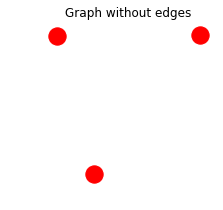

In [10]:
# Node features.
nodes = [[10.],  # Node 0
         [11.],  # Node 1
         [12.]]  # Node 2

data_dict = {
    "nodes": nodes,
}

graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])

# We can visualize the graph using networkx.
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
_ = ax.set_title("Graph without edges")

### Creating a `GraphsTuple` from a `networkx` graph

[`networkx`](https://networkx.github.io/) is a powerful graph manipulation library in  Python. A `GraphsTuple` to be built from `networkx` graphs as follows:

Shapes of `GraphsTuple`'s fields:
GraphsTuple(nodes=(4, 2), edges=(3, 2), receivers=(3,), senders=(3,), globals=(1, 3), n_node=(1,), n_edge=(1,))

Data contained in `GraphsTuple`'s fields:
globals:
[[0.6 0.7 0.8]]
nodes:
[[0.3 1.3]
 [0.4 1.4]
 [0.5 1.5]
 [0.6 1.6]]
edges:
[[3.6 3.7]
 [5.6 5.7]
 [6.6 6.7]]
senders:
[0 2 3]
receivers:
[1 0 0]
n_node:
[4]
n_edge:
[3]


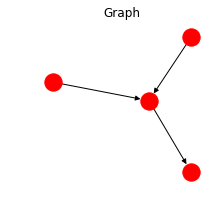

In [11]:
graph_nx = nx.OrderedMultiDiGraph()

# Globals.
graph_nx.graph["features"] = np.array([0.6, 0.7, 0.8])

# Nodes.
graph_nx.add_node(0, features=np.array([0.3, 1.3]))
graph_nx.add_node(1, features=np.array([0.4, 1.4]))
graph_nx.add_node(2, features=np.array([0.5, 1.5]))
graph_nx.add_node(3, features=np.array([0.6, 1.6]))
# Edges.
graph_nx.add_edge(0, 1, features=np.array([3.6, 3.7]))
graph_nx.add_edge(2, 0, features=np.array([5.6, 5.7]))
graph_nx.add_edge(3, 0, features=np.array([6.6, 6.7]))

ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graph_nx, ax=ax)
ax.set_title("Graph")

graphs_tuple = utils_np.networkxs_to_graphs_tuple([graph_nx])

print_graphs_tuple(graphs_tuple)

## Working with tensor `GraphsTuple`'s

In [12]:
#@title #### (Define functions for generating and plotting graphs)

GLOBAL_SIZE = 4
NODE_SIZE = 5
EDGE_SIZE = 6

def get_graph_data_dict(num_nodes, num_edges):
  return {
      "globals": np.random.rand(GLOBAL_SIZE).astype(np.float32),
      "nodes": np.random.rand(num_nodes, NODE_SIZE).astype(np.float32),
      "edges": np.random.rand(num_edges, EDGE_SIZE).astype(np.float32),
      "senders": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
      "receivers": np.random.randint(num_nodes, size=num_edges, dtype=np.int32),
  }

graph_3_nodes_4_edges = get_graph_data_dict(num_nodes=3, num_edges=4)
graph_5_nodes_8_edges = get_graph_data_dict(num_nodes=5, num_edges=8)
graph_7_nodes_13_edges = get_graph_data_dict(num_nodes=7, num_edges=13)
graph_9_nodes_25_edges = get_graph_data_dict(num_nodes=9, num_edges=25)

graph_dicts = [graph_3_nodes_4_edges, graph_5_nodes_8_edges,
               graph_7_nodes_13_edges, graph_9_nodes_25_edges]

def plot_graphs_tuple_np(graphs_tuple):
  networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
  num_graphs = len(networkx_graphs)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  for graph, ax in zip(networkx_graphs, axes):
    plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
  node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
  edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
  global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

  if pos is None:
    pos = nx.spring_layout(graph)
  nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

  if edge_labels:
    nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

  if global_label:
    plt.text(0.05, 0.95, global_label, transform=ax.transAxes)

  ax.yaxis.set_visible(False)
  ax.xaxis.set_visible(False)
  return pos


def plot_compare_graphs(graphs_tuples, labels):
  pos = None
  num_graphs = len(graphs_tuples)
  _, axes = plt.subplots(1, num_graphs, figsize=(5*num_graphs, 5))
  if num_graphs == 1:
    axes = axes,
  pos = None
  for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
    graph = utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]
    pos = plot_graph_networkx(graph, ax, pos=pos)
    ax.set_title(name)

## Creating a constant tensor `GraphsTuple` from data dicts

Similar to `utils_np.data_dicts_to_graphs_tuple`,  the `utils_tf` module, which manipulates graphs whose attributes are represented as TensorFlow tensors, contains a function named [`utils_tf.data_dicts_to_graphs_tuple`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#utils_tfgraphs_tuple_to_data_dictsgraph), which creates a constant tensor graph from data dicts, containing either numpy arrays of tensors.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


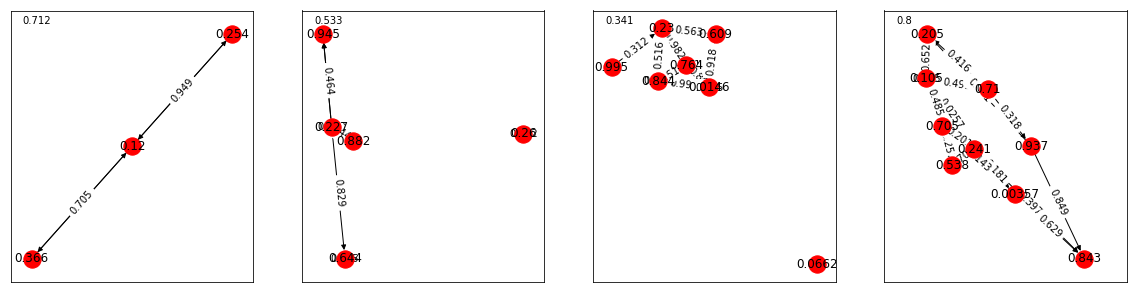

In [13]:
tf.reset_default_graph()
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

with tf.Session() as sess:
  graphs_tuple_np = sess.run(graphs_tuple_tf)

plot_graphs_tuple_np(graphs_tuple_np)

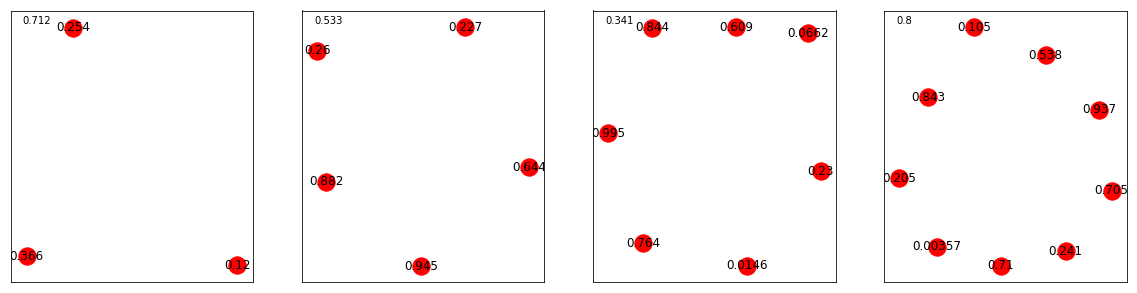

In [14]:
# If the GraphsTuple has None's we need to make use of `utils_tf.make_runnable_in_session`.
tf.reset_default_graph()
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

# Removing the edges from a graph.
graph_with_nones = graphs_tuple_tf.replace(
    edges=None, senders=None, receivers=None, n_edge=graphs_tuple_tf.n_edge*0)

runnable_in_session_graph = utils_tf.make_runnable_in_session(graph_with_nones)
with tf.Session() as sess:
  graphs_tuple_np = sess.run(runnable_in_session_graph)

plot_graphs_tuple_np(graphs_tuple_np)

## `GraphsTuple` placeholders

In TensorFlow, data is often passed into a session via [placeholder tensors](https://www.tensorflow.org/api_docs/python/tf/placeholder). The cell below shows how to create placeholders for graph data.

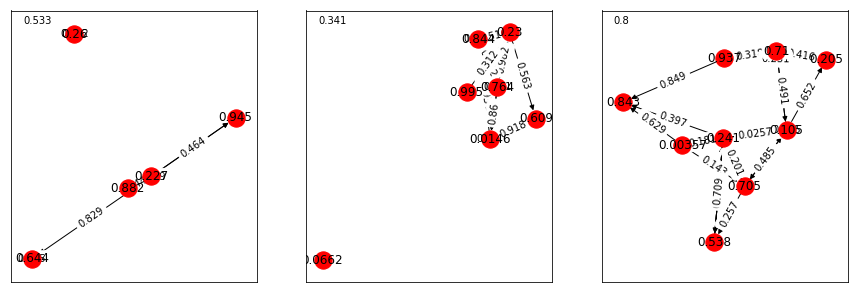

In [15]:
tf.reset_default_graph()

# Create a placeholder using the first graph in the list as template.
graphs_tuple_ph = utils_tf.placeholders_from_data_dicts(graph_dicts[0:1])

with tf.Session() as sess:
  # Feeding a batch of graphs with different sizes, and different
  # numbers of nodes and edges through the placeholder.
  feed_dict = utils_tf.get_feed_dict(
      graphs_tuple_ph, utils_np.data_dicts_to_graphs_tuple(graph_dicts[1:]))

  graphs_tuple_np = sess.run(graphs_tuple_ph, feed_dict)

plot_graphs_tuple_np(graphs_tuple_np)

A similar utility is provided to work with `networkx` graphs: [`utils_np.data_dict_to_networkx`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#utils_npdata_dict_to_networkxdata_dict).

## Slicing graphs from within a batch

A subset of graphs can be retrieved from a batch represented by `GraphsTuple` as follows.

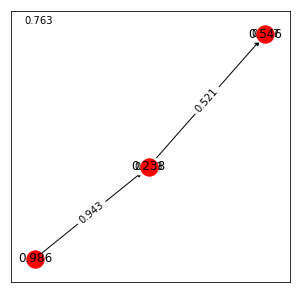

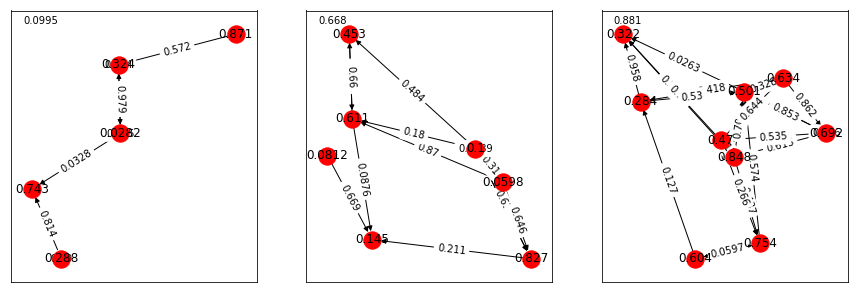

In [16]:
# If the GraphsTuple has None's we need to make use of `utils_tf.make_runnable_in_session`.
tf.reset_default_graph()
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

first_graph_tf = utils_tf.get_graph(graphs_tuple_tf, 0)
three_graphs_tf = utils_tf.get_graph(graphs_tuple_tf, slice(1, 4))

with tf.Session() as sess:
  first_graph_np = sess.run(first_graph_tf)
  three_graphs_np = sess.run(three_graphs_tf)

plot_graphs_tuple_np(first_graph_np)
plot_graphs_tuple_np(three_graphs_np)

## Concatenating multiple `GraphsTuple` instances

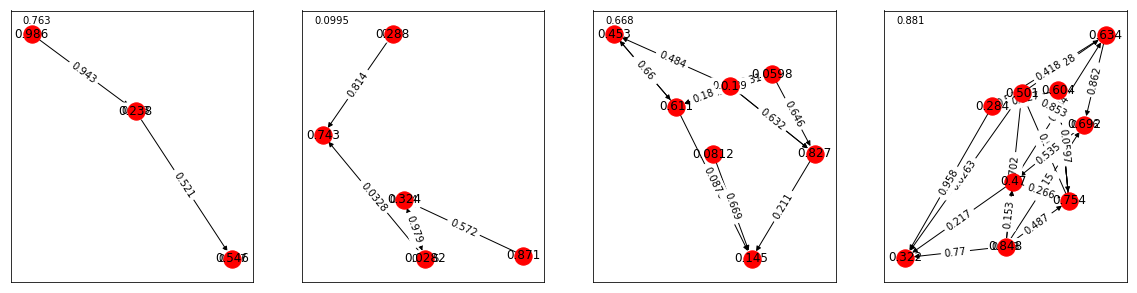

In [17]:
# Concatenating along the batch dimension
tf.reset_default_graph()
graphs_tuple_1_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts[0:1])
graphs_tuple_2_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts[1:])

graphs_tuple_tf = utils_tf.concat([graphs_tuple_1_tf, graphs_tuple_2_tf], axis=0)

with tf.Session() as sess:
  graphs_tuple_np = sess.run(graphs_tuple_tf)

plot_graphs_tuple_np(graphs_tuple_np)

Similarly, we can concatenate along feature dimensions, assuming all of the batches to be concatenates have the same graph structure/connectivity.

See `utils_tf` for more methods to work with GraphsTuple's containing tensors.

# Graph Net modules

So far we've covered how to manipulate graph-structured data via the `GraphsTuple` class and the `utils_np` and `utils_tf` utilities. Now we show how to use actual graph networks.

## Creating a [`modules.GraphNetwork`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesgraphnetwork)

![Graph Network block](https://github.com/deepmind/graph_nets/raw/master/images/graph-network.png)

A graph network has up to three learnable sub-functions: edge ($\phi^e$), node ($\phi^v$), and global ($\phi^u$) in the schematic above. See Section 3.2.2, page 12 in [our companion arXiv paper](https://arxiv.org/pdf/1806.01261.pdf) for details.

To instantiate a graph network module in the library, these sub-functions are specified via constructor arguments which are `callable`s that return Sonnet modules, such as `snt.Linear` or `snt.nets.MLP`.

The reason that a `callable` is provided, instead of the module/method directly, is so the Graph Net object owns the modules and the variables created by them.

In [18]:
tf.reset_default_graph()
OUTPUT_EDGE_SIZE = 10
OUTPUT_NODE_SIZE = 11
OUTPUT_GLOBAL_SIZE = 12
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=OUTPUT_EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=OUTPUT_NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=OUTPUT_GLOBAL_SIZE))

## Feeding a `GraphsTuple` to a Graph Net

A `GraphsTuple` can be fed into a graph network, which returns an output graph with the same number of nodes, edges, and edge connectivity, but with updated edge, node and global features. All of the output features are conditioned on the input features according to the graph structure, and are fully differentiable.

In [19]:
input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
output_graphs = graph_network(input_graphs)

print("Output edges size: {}".format(output_graphs.edges.shape[-1]))  # Equal to OUTPUT_EDGE_SIZE
print("Output nodes size: {}".format(output_graphs.nodes.shape[-1]))  # Equal to OUTPUT_NODE_SIZE
print("Output globals size: {}".format(output_graphs.globals.shape[-1]))  # Equal to OUTPUT_GLOBAL_SIZE

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Output edges size: 10
Output nodes size: 11
Output globals size: 12


## Connecting a `GraphNetwork` recurrently

A Graph Net module can be chained recurrently by matching the output feature sizes to the input feature sizes, and feeding the output back to the input multiple times ([arXiv paper](https://arxiv.org/abs/1806.01261), bottom of Fig. 6a).

In [20]:
tf.reset_default_graph()

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=GLOBAL_SIZE))

num_recurrent_passes = 3
previous_graphs = input_graphs
for unused_pass in range(num_recurrent_passes):
  previous_graphs = graph_network(previous_graphs)
output_graphs = previous_graphs

Alternatively, we can process the input graph multiple times with a graph state that gets updated recurrently.

In [21]:
def zeros_graph(sample_graph, edge_size, node_size, global_size):
  zeros_graphs = sample_graph.replace(nodes=None, edges=None, globals=None)
  zeros_graphs = utils_tf.set_zero_edge_features(zeros_graphs, edge_size)
  zeros_graphs = utils_tf.set_zero_node_features(zeros_graphs, node_size)
  zeros_graphs = utils_tf.set_zero_global_features(zeros_graphs, global_size)
  return zeros_graphs

tf.reset_default_graph()

graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=OUTPUT_EDGE_SIZE),
    node_model_fn=lambda: snt.Linear(output_size=OUTPUT_NODE_SIZE),
    global_model_fn=lambda: snt.Linear(output_size=OUTPUT_GLOBAL_SIZE))

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
initial_state = zeros_graph(
    input_graphs, OUTPUT_EDGE_SIZE, OUTPUT_NODE_SIZE, OUTPUT_GLOBAL_SIZE)

num_recurrent_passes = 3

current_state = initial_state
for unused_pass in range(num_recurrent_passes):
  input_and_state_graphs = utils_tf.concat(
      [input_graphs, current_state], axis=1)
  current_state = graph_network(input_and_state_graphs)
output_graphs = current_state

Similarly, recurrent modules with gating, such as an LSTM or GRU, can be applied on the edges, nodes, and globals of the state and input graphs separately.

## Other canonical Graph Net modules

Other canonical modules discussed in Figure 4 of our [arXiv paper](https://arxiv.org/abs/1806.01261) are provided in `graph_nets.modules`:
- [`modules.GraphIndependent`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesgraphindependent) (updates the global, node, and edge features independently, without message-passing)
- [`modules.InteractionNetwork`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesinteractionnetwork) (an example of a "Message-passing neural network")
- [`modules.CommNet`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulescommnet) (another example of a "Message-passing neural network")
- [`modules.SelfAttention`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesselfattention) (an example of a "Non-local neural network")
- [`modules.RelationNetwork`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesrelationnetwork)
- [`modules.DeepSets`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-modulesdeepsets)

See documentation for more details and corresponding references.

# Graph Net building blocks

Custom graph net modules can be built using a few basic building blocks provided in `graph_nets.blocks`.

## Broadcast operations

Broadcast operations allow to transfer information between different types of elements in the graph:
- [`blocks.broadcast_globals_to_nodes`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_globals_to_nodesgraph-namebroadcast_globals_to_nodes): Copy/broadcast global features across all nodes.
- [`blocks.broadcast_globals_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_globals_to_edgesgraph-namebroadcast_globals_to_edges): Copy/broadcast global features across all edges.
- [`blocks.broadcast_sender_nodes_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_sender_nodes_to_edgesgraph-namebroadcast_sender_nodes_to_edges): Copy/broadcast node information from each node, across all edges for which that node is a sender.
- [`blocks.broadcast_receiver_nodes_to_edges`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksbroadcast_receiver_nodes_to_edgesgraph-namebroadcast_receiver_nodes_to_edges): Copy/broadcast node information from each node, across all edges for which that node is a receiver.

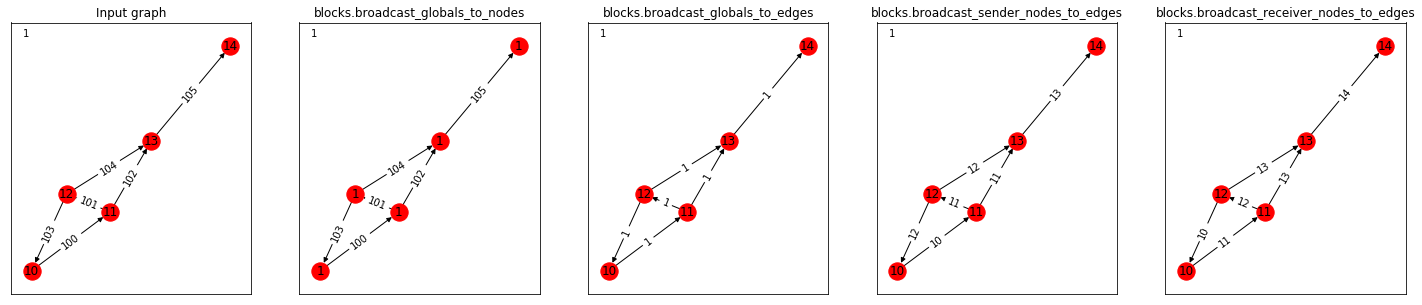

In [22]:
tf.reset_default_graph()

graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict_0])
updated_broadcast_globals_to_nodes = graphs_tuple.replace(
    nodes=blocks.broadcast_globals_to_nodes(graphs_tuple))
updated_broadcast_globals_to_edges = graphs_tuple.replace(
    edges=blocks.broadcast_globals_to_edges(graphs_tuple))
updated_broadcast_sender_nodes_to_edges = graphs_tuple.replace(
    edges=blocks.broadcast_sender_nodes_to_edges(graphs_tuple))
updated_broadcast_receiver_nodes_to_edges = graphs_tuple.replace(
    edges=blocks.broadcast_receiver_nodes_to_edges(graphs_tuple))

with tf.Session() as sess:
  output_graphs = sess.run([
      graphs_tuple,
      updated_broadcast_globals_to_nodes,
      updated_broadcast_globals_to_edges,
      updated_broadcast_sender_nodes_to_edges,
      updated_broadcast_receiver_nodes_to_edges])

plot_compare_graphs(output_graphs, labels=[
    "Input graph",
    "blocks.broadcast_globals_to_nodes",
    "blocks.broadcast_globals_to_edges",
    "blocks.broadcast_sender_nodes_to_edges",
    "blocks.broadcast_receiver_nodes_to_edges"])

We can easily use broadcasters to, for example, set the value of each edge to be the sum of the first feature element of: the input edges, the sender nodes, the receiver nodes, and the global feature.


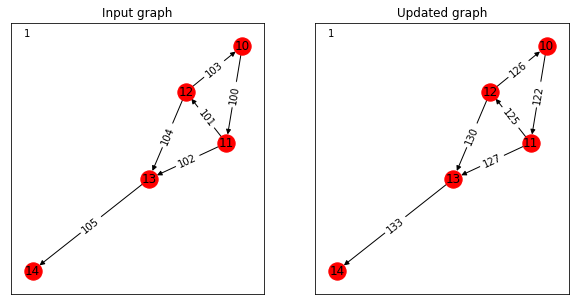

In [23]:
tf.reset_default_graph()
graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict_0])

updated_graphs_tuple = graphs_tuple.replace(
    edges=(graphs_tuple.edges[:, :1] +
           blocks.broadcast_receiver_nodes_to_edges(graphs_tuple)[:, :1] +
           blocks.broadcast_sender_nodes_to_edges(graphs_tuple)[:, :1] +
           blocks.broadcast_globals_to_edges(graphs_tuple)[:, :1]))

with tf.Session() as sess:
  output_graphs = sess.run([
      graphs_tuple,
      updated_graphs_tuple])

plot_compare_graphs(output_graphs, labels=[
    "Input graph",
    "Updated graph"])

## Aggregators

Aggregators perform reduce operations between different elements of the graph:

- [`blocks.EdgesToGlobalsAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksedgestoglobalsaggregator): Aggregates the sets of features for all edges into a single global set of features.
- [`blocks.NodesToGlobalsAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksnodestoglobalsaggregator): Aggregates the sets of features for all nodes into a single global set of features.
- [`blocks.SentEdgesToNodesAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blockssentedgestonodesaggregator): Aggregates the sets of features for all edges sent by each node into a single set of features for that node.
- [`blocks.ReceivedEdgesToNodesAggregator`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksreceivededgestonodesaggregator): Aggregates the sets of features for all edges received by each node into a single set of features for that.

Different types of reduce operations are:
- [`tf.unsorted_segment_sum`](https://www.tensorflow.org/api_docs/python/tf/unsorted_segment_sum): Elementwise sum. Set to 0 for empty sets.
- [`tf.unsorted_segment_mean`](https://www.tensorflow.org/api_docs/python/tf/unsorted_segment_mean): Elementwise mean. Set to 0 for empty sets.
- [`tf.unsorted_segment_prod`](https://www.tensorflow.org/api_docs/python/tf/unsorted_segment_prod): Elementwise prod. Set to 1 for empty sets.
- [`blocks.unsorted_segment_max_or_zero`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksunsorted_segment_max_or_zerovalues-indices-num_groups-nameunsorted_segment_max_or_zero): Elementwise max. Set to 0 for empty sets.
- [`blocks.unsorted_segment_min_or_zero`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#blocksunsorted_segment_max_or_zerovalues-indices-num_groups-nameunsorted_segment_min_or_zero): Elementwise min. Set to 0 for empty sets.


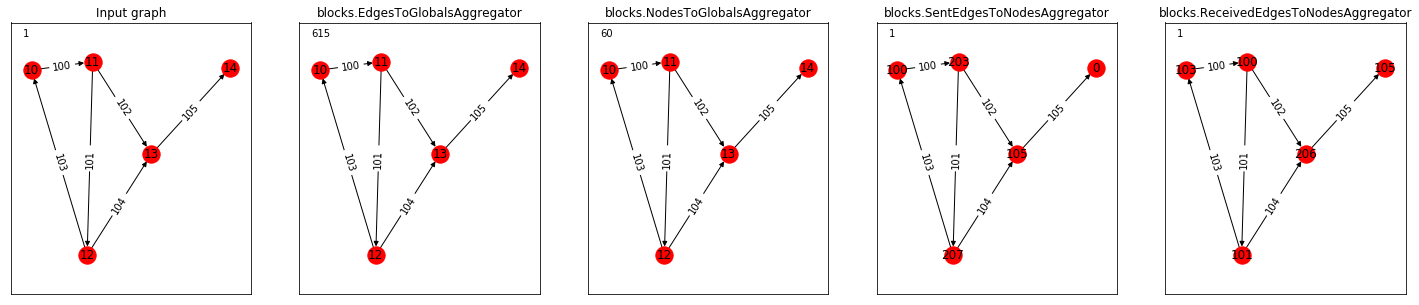

In [24]:
tf.reset_default_graph()

graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict_0])

reducer = tf.unsorted_segment_sum
updated_edges_to_globals = graphs_tuple.replace(
    globals=blocks.EdgesToGlobalsAggregator(reducer=reducer)(graphs_tuple))
updated_nodes_to_globals = graphs_tuple.replace(
    globals=blocks.NodesToGlobalsAggregator(reducer=reducer)(graphs_tuple))
updated_sent_edges_to_nodes = graphs_tuple.replace(
    nodes=blocks.SentEdgesToNodesAggregator(reducer=reducer)(graphs_tuple))
updated_received_edges_to_nodes = graphs_tuple.replace(
    nodes=blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(graphs_tuple))

with tf.Session() as sess:
  output_graphs = sess.run([
      graphs_tuple,
      updated_edges_to_globals,
      updated_nodes_to_globals,
      updated_sent_edges_to_nodes,
      updated_received_edges_to_nodes])

plot_compare_graphs(output_graphs, labels=[
    "Input graph",
    "blocks.EdgesToGlobalsAggregator",
    "blocks.NodesToGlobalsAggregator",
    "blocks.SentEdgesToNodesAggregator",
    "blocks.ReceivedEdgesToNodesAggregator"])

## [`blocks.EdgeBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksedgeblock)

An EdgeBlock consists of applying a function to the concatenation of:
-  `graphs_tuple.edges`
- `blocks.broadcast_sender_nodes_to_edges(graphs_tuple)`
- `blocks.broadcast_receiver_nodes_to_edges(graphs_tuple)`
- `blocks.broadcast_globals_to_edges(graphs_tuple)`

The result is a graph with new edge features conditioned on input edges, nodes and global features according to the graph structure.

In [25]:
tf.reset_default_graph()
edge_block = blocks.EdgeBlock(
    edge_model_fn=lambda: snt.Linear(output_size=10))

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
output_graphs = edge_block(input_graphs)

print(("Output edges size: {}".format(output_graphs.edges.shape[-1])))

Output edges size: 10


## [`blocks.NodeBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksnodeblock)

An NodeBlock consists of applying a function to the concatenation of:
-  `graphs_tuple.nodes`
- `blocks.ReceivedEdgesToNodesAggregator(<reducer-function>)(graphs_tuple)`
- `blocks.broadcast_globals_to_nodes(graphs_tuple)`

The result is a graph with new node features conditioned on input edges, nodes and global features according to the graph structure.

In [26]:
tf.reset_default_graph()
node_block = blocks.NodeBlock(
    node_model_fn=lambda: snt.Linear(output_size=15))

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
output_graphs = node_block(input_graphs)

print(("Output nodes size: {}".format(output_graphs.nodes.shape[-1])))

Output nodes size: 15


## [`blocks.GlobalBlock`](https://github.com/deepmind/graph_nets/blob/master/docs/graph_nets.md#class-blocksglobalblock)

An GlobalBlock consists of applying a function to the concatenation of:

- `graphs_tuple.globals`
- `blocks.EdgesToGlobalsAggregator(<reducer-function>)(graphs_tuple)`
- `blocks.NodesToGlobalsAggregator(<reducer-function>)(graphs_tuple)`

The result is a graph with new globals features conditioned on input edges, nodes and global features.

In [27]:
tf.reset_default_graph()
global_block = blocks.GlobalBlock(
    global_model_fn=lambda: snt.Linear(output_size=20))

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
output_graphs = global_block(input_graphs)

print(("Output globals size: {}".format(output_graphs.globals.shape[-1])))

Output globals size: 20


## Block compositionality

A `modules.GraphNetwork` is composed internally of a `modules.EdgeBlock`,  a `modules.NodeBlock`, and a `modules.GlobalBlock`, connected serially. This allows every field in the output to be conditioned by any field in the input.

In [28]:
tf.reset_default_graph()
graph_network = modules.GraphNetwork(
    edge_model_fn=lambda: snt.Linear(output_size=10),
    node_model_fn=lambda: snt.Linear(output_size=15),
    global_model_fn=lambda: snt.Linear(output_size=20))

input_graphs = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
output_graphs = graph_network(input_graphs)

for var in graph_network.variables:
  print(var)

<tf.Variable 'graph_network/edge_block/linear/b:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'graph_network/edge_block/linear/w:0' shape=(20, 10) dtype=float32_ref>
<tf.Variable 'graph_network/global_block/linear/b:0' shape=(20,) dtype=float32_ref>
<tf.Variable 'graph_network/global_block/linear/w:0' shape=(29, 20) dtype=float32_ref>
<tf.Variable 'graph_network/node_block/linear/b:0' shape=(15,) dtype=float32_ref>
<tf.Variable 'graph_network/node_block/linear/w:0' shape=(19, 15) dtype=float32_ref>


### Most of the existing neural networks operating on graphs can be built upon this set of building blocks using their different configuration options. See `graph_nets.modules` for some examples.